In [442]:
# import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib notebook
%matplotlib inline
import seaborn as sns
import matplotlib.dates as mdates
import geopandas as gpd
import geoplot as gplt
import mapclassify as mc


In [443]:
# Question 1
# creating raw data
# read files
patterns_2018 = pd.read_csv('weekly_patterns_2018_sample.csv.zip', 
                            compression = 'zip')
patterns_2019 = pd.read_csv('weekly_patterns_2019_sample.csv.zip', 
                            compression = 'zip')
patterns_2020 = pd.read_csv('weekly_patterns_2020_sample.csv.zip', 
                            compression = 'zip')
patterns_2021 = pd.read_csv('weekly_patterns_2021_sample.csv.zip', 
                            compression = 'zip')
patterns_2022 = pd.read_csv('weekly_patterns_2022_sample.csv.zip', 
                            compression = 'zip')
# Question 1b
patternsList = [patterns_2018, patterns_2019, 
                
                patterns_2020, patterns_2021, patterns_2022];

# Initialize an empty list to hold the filtered DataFrames
filtered_patterns = []

# Initialize DataFrame to hold data for my restaurant chain
myRest = pd.DataFrame();

# Loop through each DataFrame in the list
for pattern in patternsList:
    # Filter for 'Wingstop' and add the result to the list
    filtered_myRest = pattern[pattern['brands'] == 'Wingstop']
    filtered_patterns.append(filtered_myRest)

# Concatenate all filtered DataFrames in the list
myRest = pd.concat(filtered_patterns, ignore_index=True)
# Save myRest to csv
myRest.to_csv('wingstop_data_project_1_v2.csv')
# Question 2a
# Convert string date to datetime
myRest['date_range_start'] = pd.to_datetime(myRest
                    ['date_range_start'], utc=True)
myRest['date_range_end'] = pd.to_datetime(myRest
                    ['date_range_end'], utc=True)
# Question 2b
# Remove brackets from visits_by_day column
myRest['visits_by_day'] = (
    myRest['visits_by_day'].str.replace('[', ''))
myRest['visits_by_day'] = (
    myRest['visits_by_day'].str.replace(']', ''))

# Separate entire week of visits into separate columns
myRest['dailyvisits_1'] = (
    myRest['visits_by_day'].str.split(',').str[0])
myRest['dailyvisits_2'] = (
    myRest['visits_by_day'].str.split(',').str[1])
myRest['dailyvisits_3'] = (
    myRest['visits_by_day'].str.split(',').str[2])
myRest['dailyvisits_4'] = (
    myRest['visits_by_day'].str.split(',').str[3])
myRest['dailyvisits_5'] = (
    myRest['visits_by_day'].str.split(',').str[4])
myRest['dailyvisits_6'] = (
    myRest['visits_by_day'].str.split(',').str[5])
myRest['dailyvisits_7'] = (
    myRest['visits_by_day'].str.split(',').str[6])
# Drop original column 
myRest = myRest.drop(['visits_by_day'], axis=1)
# Question 2c
# Reshape data from wide to long
# Create an id
myRest['id'] = myRest.index
# Call my reshaped data "long"
myRest_long = pd.wide_to_long(myRest, 
    ['dailyvisits'], i = 'id', j = 'daysoftheweek', sep = '_')

# Convert dailyvisits to integer
myRest_long['dailyvisits'] = myRest_long['dailyvisits'].astype(float)
# Extract year from dates
myRest_long['year'] = (
    myRest_long['date_range_start'].dt.year)
# Make a variable to get exact day of observation
myRest_long['exact_date'] = (myRest_long['date_range_start']+ 
    pd.to_timedelta(
    myRest_long.index.get_level_values('daysoftheweek') - 1, unit='D'))

# Extract day of week
myRest_long['dayofweek'] = myRest_long['exact_date'].dt.day_name()
# create dummy variable manyvisits
myRest_long['manyvisits'] = np.where(
    myRest_long['dailyvisits'] >= 9, 1, 0)
myRest_long['manyvisits'].value_counts()
# First we will see how many Wingstops are in each state by aggregating by state
myRest_long_agg_5 = myRest_long.groupby('region').agg(
    # Count unique locations per state
    locations_per_state=('placekey', 'nunique'),  
    # Total observations per state
    total_observations=('region', 'count'),
     # Total visits per state  
    total_visits=('dailyvisits', 'sum'), 
    # Average daily visits per state
    avg_daily_visits=('dailyvisits', 'mean'),  
    # Sum of manyvisits=1 per state
    manyvisits_observations=('manyvisits', 'sum')  
).reset_index()
# Calculate the percentage of manyvisits=1 within each state
myRest_long_agg_5['percentage_manyvisits_1'] = (
    myRest_long_agg_5['manyvisits_observations'] / 
    myRest_long_agg_5['total_observations']) * 100
# Now create dummy variable for core business locations
myRest_long_agg_5['core_biz_area'] = np.where(
    myRest_long_agg_5['locations_per_state'] >= 7, 1, 0)
myRest_long_agg_5['core_biz_area'].value_counts()
# add core_biz_area to main long data
myRest_long = pd.merge(myRest_long, 
                       myRest_long_agg_5[['region', 'core_biz_area']], 
                       on='region', 
                       how='left')

# create dummy variable for weekened
myRest_long['weekend'] = np.where(
    (myRest_long['dayofweek'] == "Sunday") | 
    (myRest_long['dayofweek'] == "Saturday"), 1, 0)

# save data to csv
myRest_long.to_csv('myRest_long.csv', index = False)

In [444]:
# Question 2a
# Describe the data
myRest_long['dailyvisits'].describe()
# Count observations equal to 0
count_zero = myRest_long['dailyvisits'].value_counts()[0]
# Count observations above 100
mask = myRest_long['dailyvisits'] >= 100
count_100 = len(myRest_long[mask])
# Count observations above 50
mask2 = myRest_long['dailyvisits'] >= 50
count_50 = len(myRest_long[mask])

There are 449,673 observations. The minimum is 0, the maximum is 2016, the mean is 7.550, and the median is 5. There are 144 observations greater than or equal to 100, and 39065 observations equal to 0. There are zero observations above 1000.

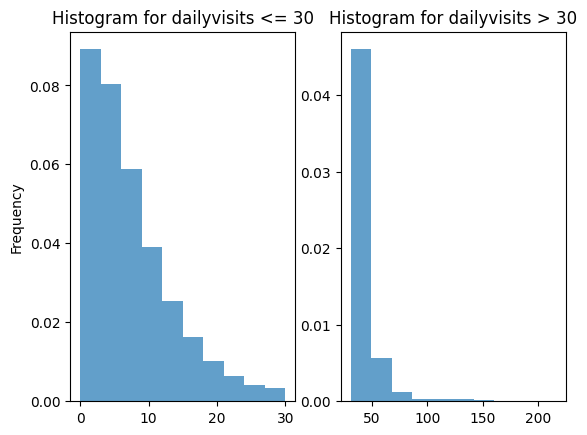

In [445]:
# Question 2b
# Subset the data into two.
# One with dailyvisits <= 30, another with dailyvisits >50.
myRest_long['small'] = np.where(myRest_long['dailyvisits'] <= 30, 1, 0)
long_small = myRest_long.loc[myRest_long['small'] == 1]
long_big = myRest_long.loc[myRest_long['small'] == 0]



fig, (ax1, ax2) = plt.subplots(1,2)
ax1.hist(long_small['dailyvisits'], bins = 10, density = True, alpha = 0.7);
ax1.set_title('Histogram for dailyvisits <= 30');
ax1.set_ylabel('Frequency')
ax2.hist(long_big['dailyvisits'], bins = 10, density = True, alpha = 0.7);
ax2.set_title('Histogram for dailyvisits > 30');

The third quartile is 10, so more than 75% of the data is below 10. When I first graphed all the observations, the data was right skewed, and most of the observations were below 30. So I chose my range as 0 to 30. To represent the rest of the data, I added a second plot to show the rest of the observations. 

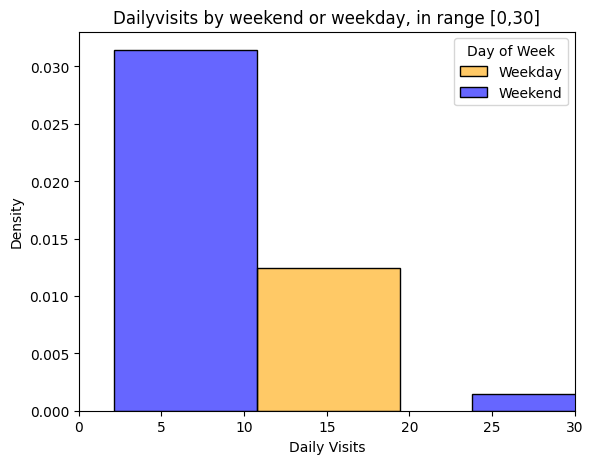

(30.0, 216.0)

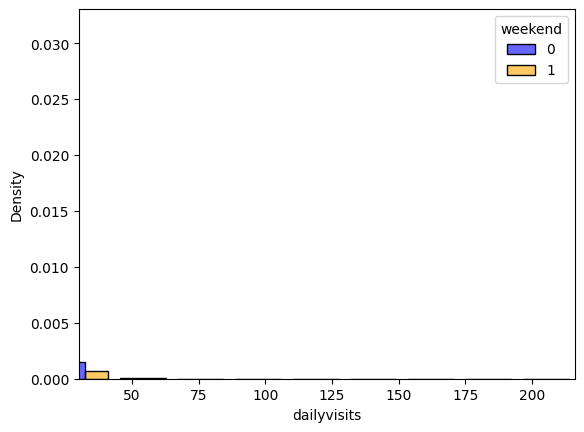

In [446]:
# Question 2c
# plot histogram grouping weekend/weekday
sns.histplot(data=myRest_long, x='dailyvisits', hue='weekend', 
             bins=10, stat='density', multiple='dodge', 
             shrink=0.8, alpha=0.6, palette=['blue', 'orange'])

# Setting the range for 'dailyvisits'
plt.xlim([0, 30])

# Adding plot title and adjusting subplot parameters
plt.title('Dailyvisits by weekend or weekday, in range [0,30]')
plt.xlabel('Daily Visits')
plt.ylabel('Density')
plt.legend(title='Day of Week', labels=['Weekday', 'Weekend'])
plt.subplots_adjust(top=0.9)
plt.show()

sns.histplot(data=myRest_long, x='dailyvisits', hue='weekend', 
             bins=10, stat='density', multiple='dodge', 
             shrink=0.8, alpha=0.6, palette=['blue', 'orange'])

# Setting the range for 'dailyvisits'
plt.xlim([30, 216])


Weekend is more spread out, with either a high amount of visits or a low amount of visits. Weekday visits are more consistent and are centered between weekday and weekend. 

In [447]:
# Question 3c
# Sum dailyvisit by day of week
dv_sum = myRest_long[['dayofweek', 'dailyvisits']].groupby('dayofweek').sum()
dv_sum

,dailyvisits
dayofweek,
Friday,586819.0
Monday,440777.0
Saturday,550953.0
Sunday,448585.0
Thursday,470521.0
Tuesday,442748.0
Wednesday,454718.0


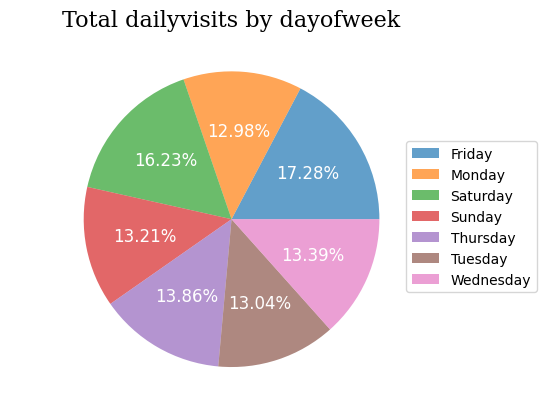

In [448]:
# Question 3c
# Make pie chart with dailyvisits by day of week
plt.figure()
plt.pie(dv_sum['dailyvisits'],
 labels = dv_sum.index,
 autopct='%.2f%%',
 textprops={'color':'w', 'fontsize': 12},
 wedgeprops={'alpha':0.7})
plt.title('Total dailyvisits by dayofweek',
 fontsize = 16,
 fontname = 'serif');
plt.legend(title='Day of Week', labels=['Friday', 'Monday',
                                         'Saturday', 'Sunday', 
                                         'Thursday', 'Tuesday',
                                         'Wednesday'])
plt.legend(bbox_to_anchor=(1,0.5),
 loc="center right",
 fontsize=10,
 bbox_transform=plt.gcf().transFigure);


In [449]:
# Question 4a
# Calculate average dailyvisits by region
region_ = myRest_long[['dailyvisits', 'region']].groupby(['region']).mean()
region_.reset_index(inplace = True)
region_


,region,dailyvisits
0,AK,15.454297
1,AL,19.902407
2,AR,4.617132
3,AZ,11.017968
4,CA,7.136379
5,CO,4.303889
6,CT,6.701299
7,DE,4.113127
8,FL,7.041722
9,GA,7.894272


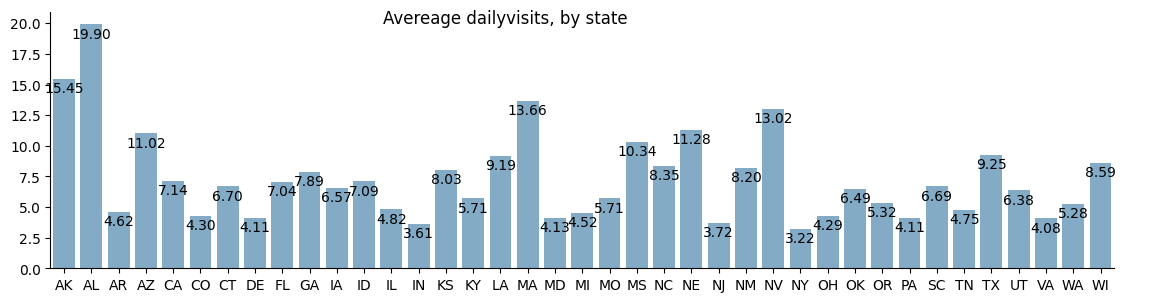

In [450]:
# Question 4b
myplot = sns.catplot(
 data=region_, kind='bar',
 x='region', y='dailyvisits',
 alpha=.6)
myplot.set_axis_labels("", "")
myplot.fig.suptitle("Avereage dailyvisits, by state",
 fontsize=12);
plt.gcf().set_size_inches(13,3)
myplot.axes[0,0].bar_label(myplot.axes[0,0].containers[0],
 fmt = '%.2f',
 padding = -12,
 color = 'black');


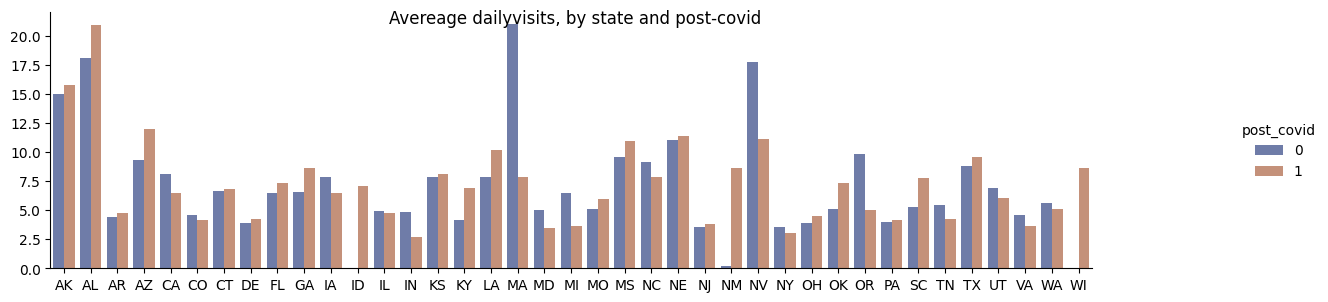

In [451]:
# Question 4
# Create dummy variable to indicate whether observation occurred post-covid
myRest_long['post_covid'] = np.where(
    (myRest_long['date_range_start'] >= '2020-03-13'), 1, 0)

region_2 = (myRest_long[['dailyvisits', 'region', 'post_covid']]
            .groupby(['region', 'post_covid']).mean())
region_2.reset_index(inplace = True)
# plot
ax = sns.catplot(
 data = region_2, kind="bar",
 x=  "region", y="dailyvisits",
 hue="post_covid",
 palette = 'dark', alpha=.6)
ax.set_axis_labels("", "")
ax.fig.suptitle("Avereage dailyvisits, by state and post-covid",
 fontsize=12);
plt.gcf().set_size_inches(15,3)


The difference between the daily visits before and after March 13, 2020 are varying. 22 out of the 39 states have higher daily visits after covid national emergency, while the others have higher daily visits before. There does not seem to be a clear pattern, as it is nearly half split between higher and lower daily visits, so there would need to be more thorough statistical testing done. However, we can see on the chart that in Indiana, Wisconsin, and New Mexico, it is probable that new Wingstop locations opened after covid. Although a small amount of states (less than 5) have a large difference between their average daily visits before and after covid, most of the states do not show a significant difference in their daily visits after covid (but further statistical testing would need to be done to confirm this). Massachussetts, Nevada, and Oregon seem to have the largest drops in daily visits after the start of the pandemic. One possible reason for this could be some restaurants shutting down.

In [452]:
# Question 5a
# aggregate data by month-year
myRest_long['year-month'] = (myRest_long['exact_date']
                             .astype(str).str[:7].astype('datetime64[ns]'))
d1 = (myRest_long
      .groupby(['placekey', 'year-month'])['dailyvisits'].sum().reset_index())
monthly_visits = (d1.groupby('year-month')['dailyvisits'].mean().reset_index()
                  .rename(columns = {'dailyvisits': 'monthly_visits'}))


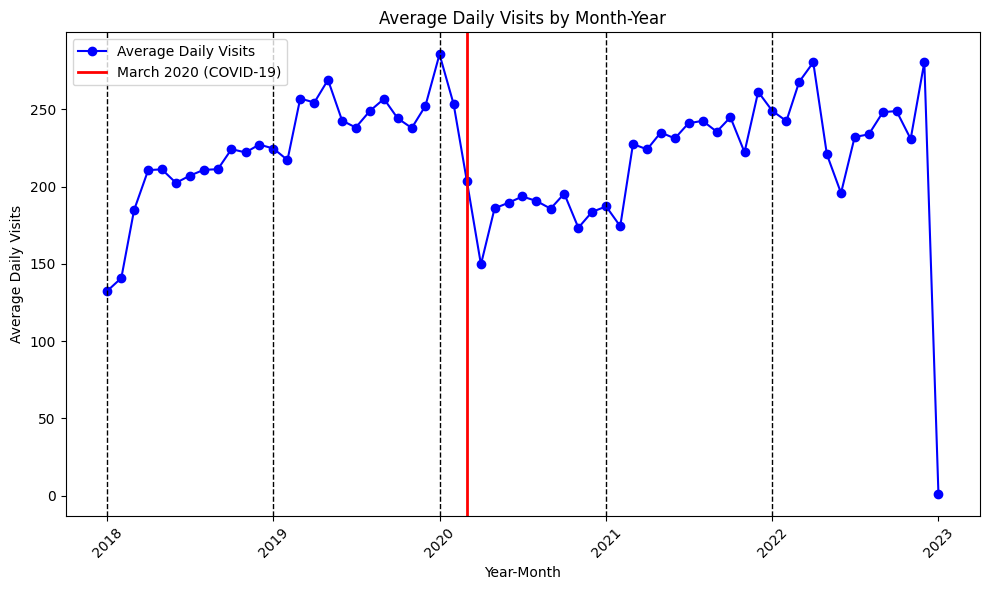

In [453]:
# Question 5b
# plot average dailyvisits
plt.figure(figsize=(10, 6))
plt.plot(monthly_visits['year-month'], monthly_visits['monthly_visits'], 
         label='Average Daily Visits', marker='o', linestyle='-', color='blue')
# Adding vertical lines for the beginning of each year
for year in range(2018, 2023):
    plt.axvline(pd.to_datetime(f'{year}-01-01'), 
                color='black', linestyle='--', linewidth=1)

# Adding a vertical line for March 2020
plt.axvline(pd.to_datetime('2020-03-01'), color='red', linestyle='-', 
            linewidth=2, label='March 2020 (COVID-19)')

# Labels, title, and legend
plt.xlabel('Year-Month')
plt.ylabel('Average Daily Visits')
plt.title('Average Daily Visits by Month-Year')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()

# Show plot
plt.show()

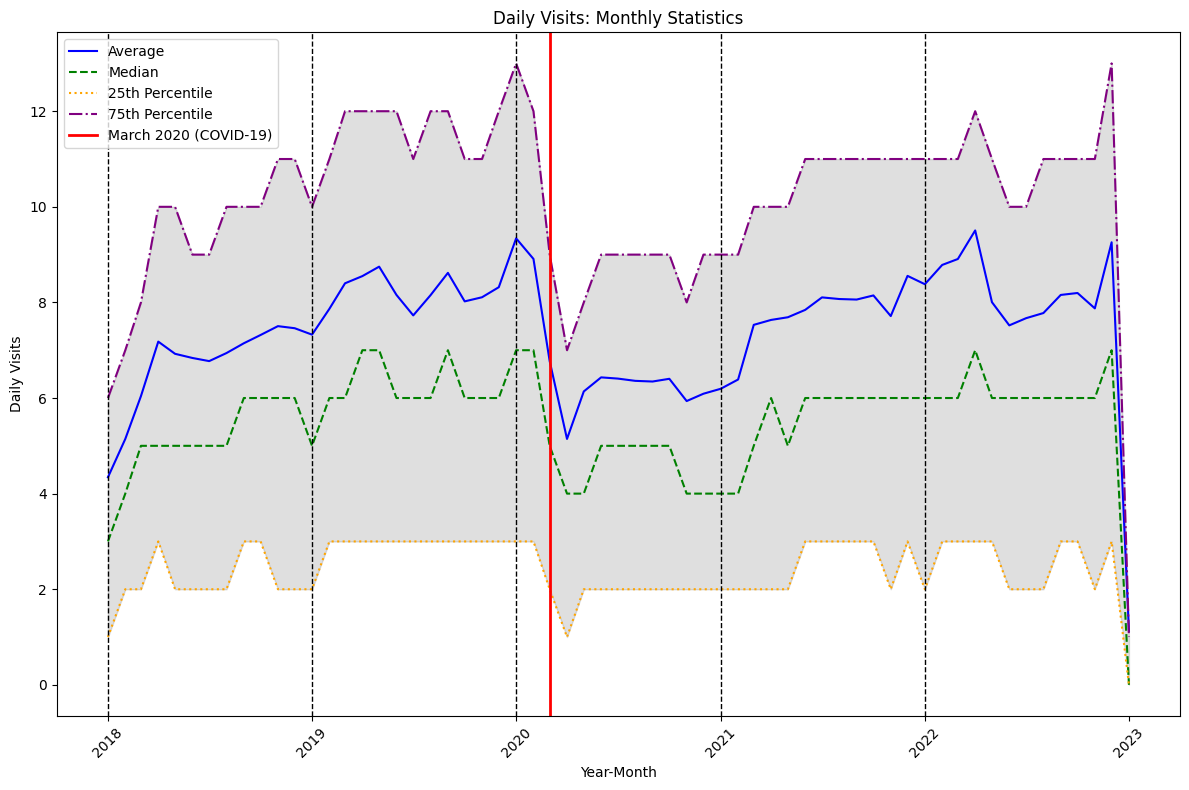

In [454]:
# Question 5c
monthly_stats = (myRest_long.groupby('year-month')['dailyvisits']
                 .agg(['mean', 'median', lambda x: x.quantile(0.25), 
                       lambda x: x.quantile(0.75)]).reset_index())
monthly_stats.columns = ['year-month', 'average', 'median', 
                         '25th_percentile', '75th_percentile']

# Plotting
plt.figure(figsize=(12, 8))

# Plotting the metrics
plt.plot(monthly_stats['year-month'], monthly_stats['average'], 
         label='Average', linestyle='-', color='blue')
plt.plot(monthly_stats['year-month'], monthly_stats['median'], 
         label='Median', linestyle='--', color='green')
plt.plot(monthly_stats['year-month'], monthly_stats['25th_percentile'], 
         label='25th Percentile', linestyle=':', color='orange')
plt.plot(monthly_stats['year-month'], monthly_stats['75th_percentile'], 
         label='75th Percentile', linestyle='-.', color='purple')

# Shade area between 25th and 75th percentile
plt.fill_between(monthly_stats['year-month'], monthly_stats['25th_percentile'], 
                 monthly_stats['75th_percentile'], color='grey', alpha=0.25)

# Adding vertical lines for the beginning of each year and March 2020
for year in range(2018, 2023):
    plt.axvline(pd.to_datetime(f'{year}-01-01'), color='black', 
                linestyle='--', linewidth=1)
plt.axvline(pd.to_datetime('2020-03-01'), color='red', 
            linestyle='-', linewidth=2, label='March 2020 (COVID-19)')

# Labels, title, and legend
plt.xlabel('Year-Month')
plt.ylabel('Daily Visits')
plt.title('Daily Visits: Monthly Statistics')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()

plt.show()

From the chart, we can see that after lockdown, it took some time for Wingstom to have as many dailyvisits as it did before. Lockdown occured near the peak dailyvisits, so dailyvisits quickly dropped. Also, there seems to be an upward trend, with more dailyvisits as time passes. Aside from covid that "reset" dailyvisits, there seems to be a positive relationship between time and dailyvisits.

C:\Users\marya\AppData\Local\Temp\ipykernel_22516\98456033.py:3: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  myRest_long['year-quarter'] = myRest_long['exact_date'].dt.to_period("Q")


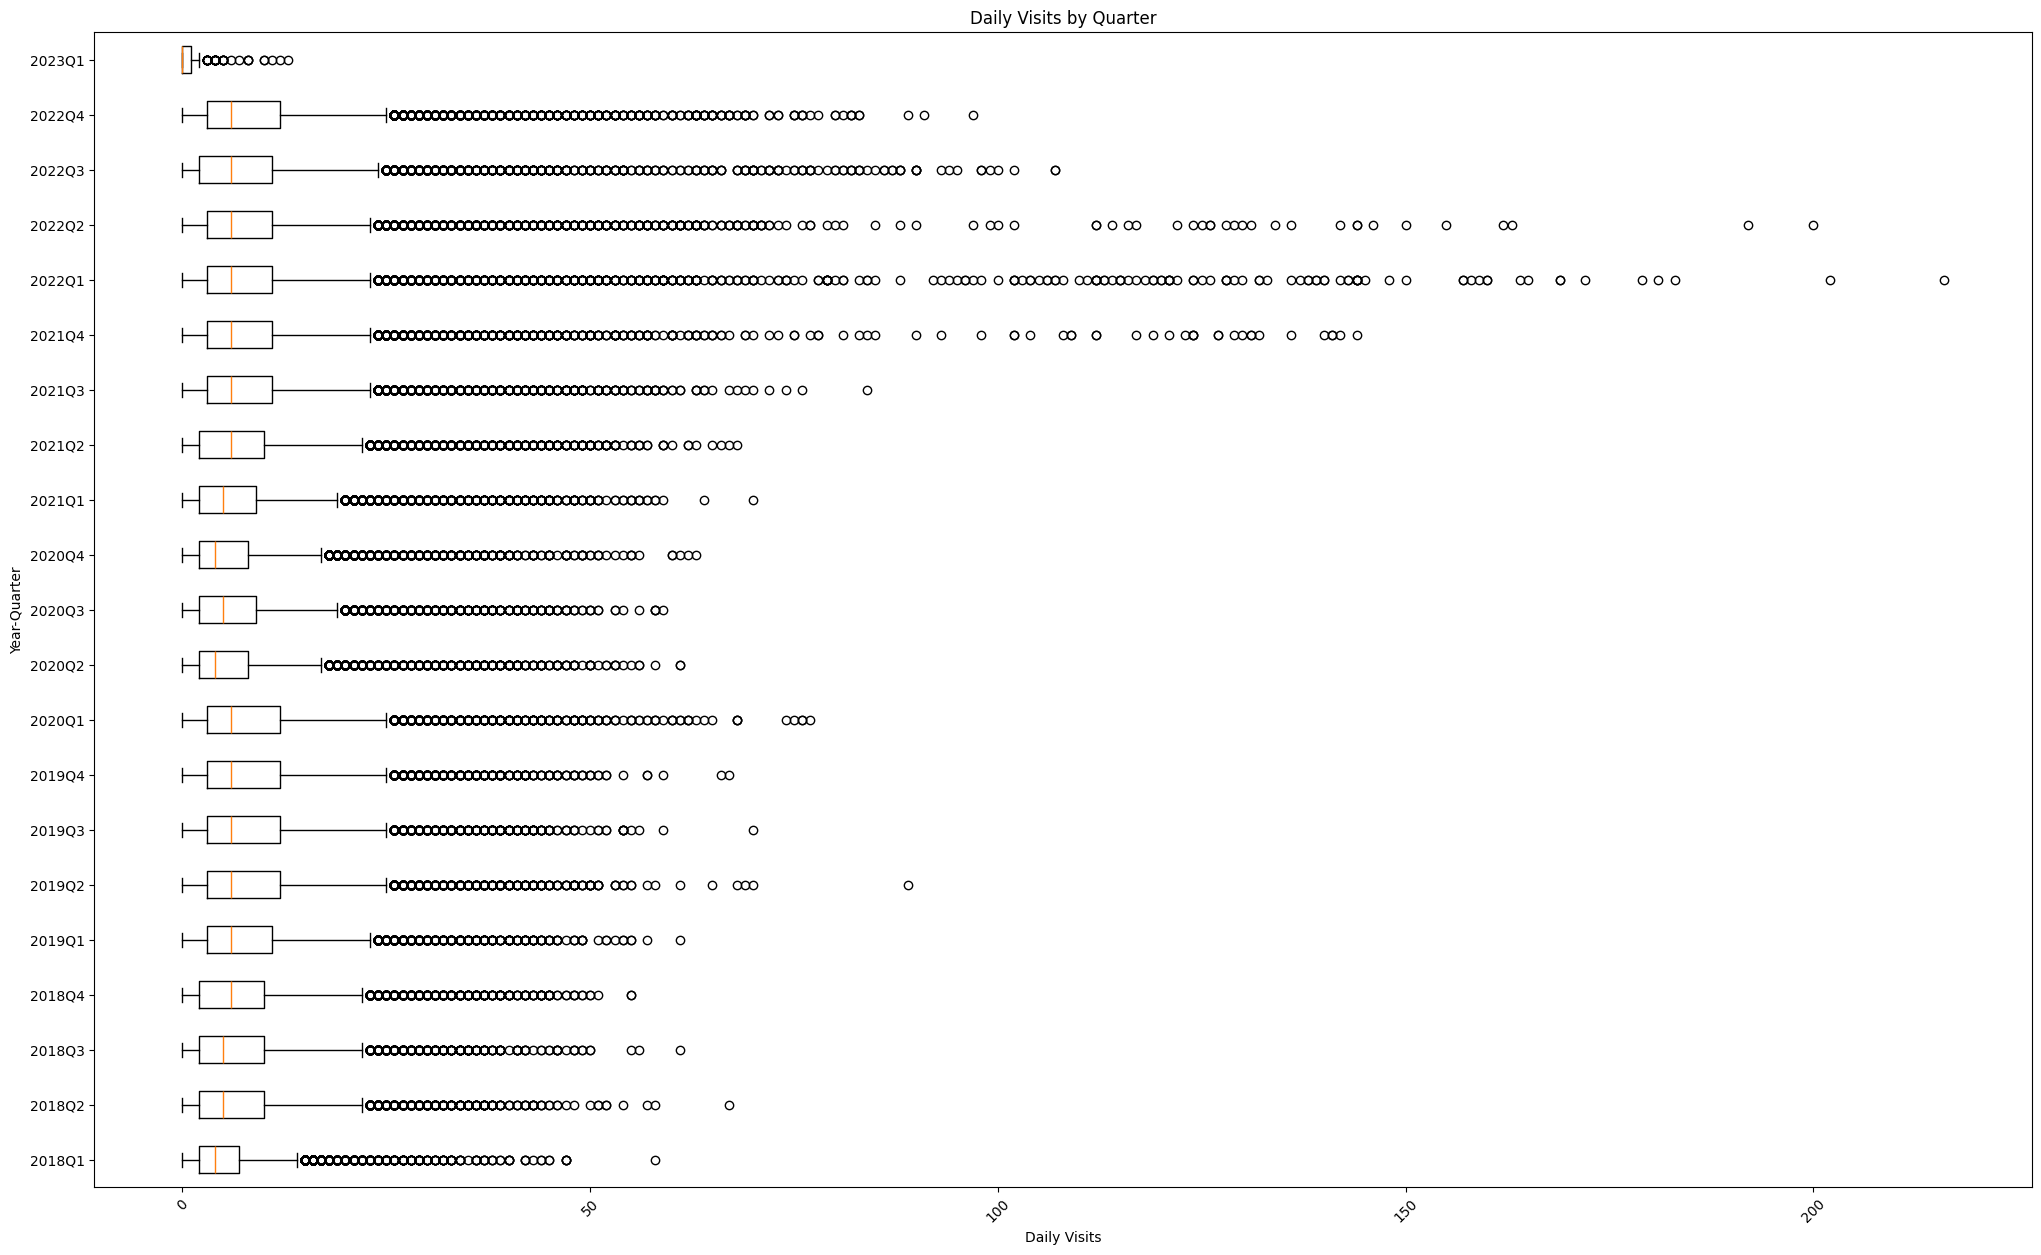

In [455]:
# Question 6
# adding a 'year-quarter' column
myRest_long['year-quarter'] = myRest_long['exact_date'].dt.to_period("Q")

# Group data by 'year-quarter' and prepare it in a format that boxplot can use
grouped_data = myRest_long.groupby('year-quarter')['dailyvisits']

# Creating a list of data for each group to pass to the boxplot function
data_to_plot = [group for name, group in grouped_data]

labels = [str(name) for name in grouped_data.groups.keys()]

fig, ax = plt.subplots(figsize=(25, 15)) 

# Create boxplot
ax.boxplot(data_to_plot, labels=labels, vert=False)

ax.set_title('Daily Visits by Quarter')
ax.set_xlabel('Daily Visits')
ax.set_ylabel('Year-Quarter')
plt.xticks(rotation=45)

plt.show()


Like we had before from summarizing the data, most of our data is focused on the right, with the 75th percentile being 10 daily visits. On the box plot, there are several observatins beyond the interquartile range. We can see a pattern in the IQR of the data. The number of dailyvisits gradually increases between 2018 and 2020 when it drops, before starting to increase again. This is similar to what we can see in the line graph. However, here, we can see that after 2021, there are a higher number of daily visits. Past the IQR, there are more observations that have higher numbers past the center of the data. While it is not many observations and does not measure to the thousands of the rest of the observations, it is interesting to see that there are more high-traffic events past 2021. This could be because of new stores opening up, stores improving, or just Wingstop becoming more popular. 

C:\Users\marya\AppData\Local\Temp\ipykernel_22516\3837155262.py:14: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  geoData = geoData.explode()


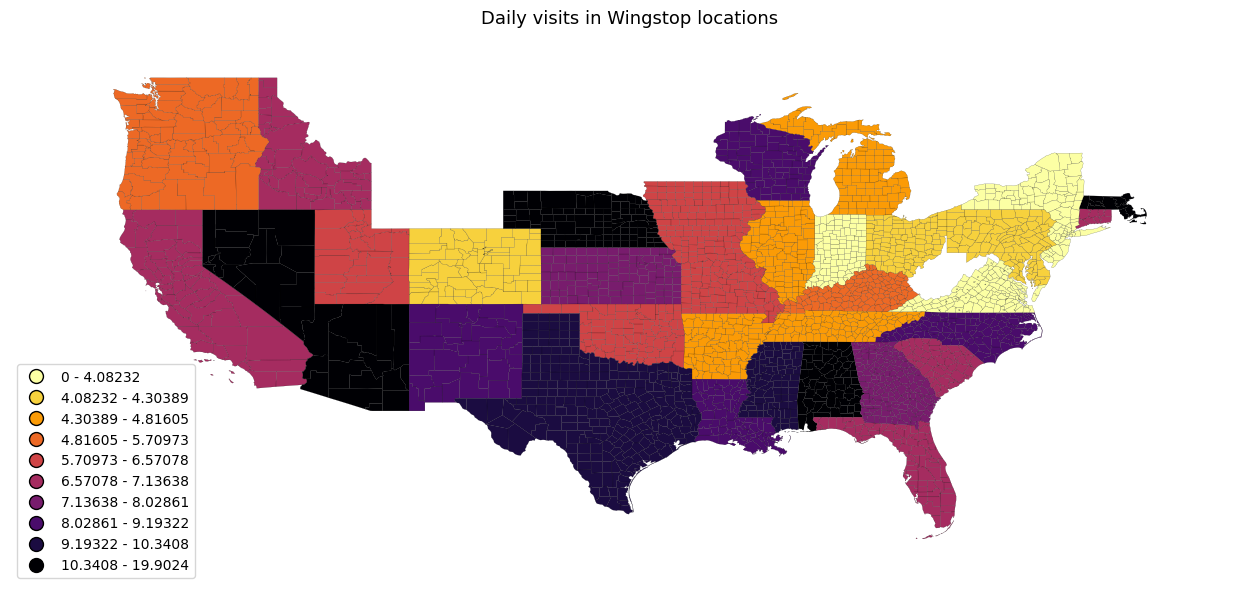

In [456]:
# Question 7
# Create map
# Load the json file with county coordinates
geoData = gpd.read_file(
    'https://raw.githubusercontent.com/holtzy/The-Python-Graph-Gallery/master/static/data/US-counties.geojson')

# Make sure the "id" column is an integer
geoData.id = geoData.id.astype(str).astype(int)

# Remove Alaska, Hawaii and Puerto Rico.
stateToRemove = ['02', '15', '72']
geoData = geoData[~geoData.STATE.isin(stateToRemove)]

# Convert MultiPolygon geometries to individual Polygon geometries
geoData = geoData.explode()

state_id = {
    'AL': '01', 'AK': '02', 'AZ': '04', 'AR': '05', 'CA': '06',
    'CO': '08', 'CT': '09', 'DE': '10', 'FL': '12', 'GA': '13',
    'HI': '15', 'ID': '16', 'IL': '17', 'IN': '18', 'IA': '19',
    'KS': '20', 'KY': '21', 'LA': '22', 'ME': '23', 'MD': '24',
    'MA': '25', 'MI': '26', 'MN': '27', 'MS': '28', 'MO': '29',
    'MT': '30', 'NE': '31', 'NV': '32', 'NH': '33', 'NJ': '34',
    'NM': '35', 'NY': '36', 'NC': '37', 'ND': '38', 'OH': '39',
    'OK': '40', 'OR': '41', 'PA': '42', 'RI': '44', 'SC': '45',
    'SD': '46', 'TN': '47', 'TX': '48', 'UT': '49', 'VT': '50',
    'VA': '51', 'WA': '53', 'WV': '54', 'WI': '55', 'WY': '56',
}

region_['state_code'] = region_['region'].map(state_id)
fullData = pd.merge(geoData, region_, left_on=['STATE'], right_on=['state_code'])

# Initialize the figure
fig, ax = plt.subplots(1, 1, figsize=(16, 12))

# Set up the color scheme:
scheme = mc.Quantiles(fullData['dailyvisits'], k=10)

# Map
gplt.choropleth(fullData, 
    hue="dailyvisits", 
    linewidth=.1,
    scheme=scheme, cmap='inferno_r',
    legend=True,
    edgecolor='black',
    ax=ax
);

ax.set_title('Daily visits in Wingstop locations', fontsize=13);

a) Based on information from scrapehero.com, the map does match the information about the distribution of Wingstop popularity around the U.S.
b) Based on the map, we can see that the states with the highest average dailyvisits are Nevada, Arizona, Alabama, North Dakota, Texas, and Massachusetts. Wingstop does not get many visits on average in Virginia, New York, New Jersey, and Indiana. This is helpful because before to find this information, I was aggregating the data on different variables and checking the data myself to see the average dailyvisits in each state. With the visualization, I can easily see which states are popular without having to program all the different steps.
c) Looking at a geographic distribution can help us decide which parts of the country are our core business areas, which parts have the most popularity, and which areas are not as popular. This is helpful for deciding where to spend money on advertising and whether we want to open more locations in a particular area. Overall, it gives us a more comprehensive picture of how Wingstop is doing around the US so that we know which states are important to focus on. 